# **0. Bibliotecas e instalação**

In [2]:
import pandas as pd
from statsbombpy import sb
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from scipy.interpolate import make_interp_spline
from matplotlib.colors import to_rgba, ListedColormap
import matplotlib.patches as patches

# **1. Parte que sera Excluida (DADOS GENERICOS DE UMA PARTIDA)**

In [8]:
MATCH_ID = 3942819
match_events_df = sb.events(match_id= MATCH_ID)
match_360_df = pd.read_json(f"../Data/{MATCH_ID}.json")
df = pd.merge(left=match_events_df, right=match_360_df, left_on='id', right_on='event_uuid', how='left')
df_on_360 = df[df['freeze_frame'].notna()]
df_on_360.iloc[1]['freeze_frame']

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


[{'teammate': True,
  'actor': True,
  'keeper': True,
  'location': [30.399999618530273, 24.100000381469727]},
 {'teammate': False,
  'actor': False,
  'keeper': False,
  'location': [39.562796968193325, 28.94501124737651]},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'location': [43.15850122106632, 37.38871647691429]},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'location': [46.19233677631486, 35.339706194857655]},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'location': [54.7951590616191, 21.73989026408779]},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'location': [62.15128581399101, 57.32615847018592]},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'location': [66.29316577818798, 40.77606882009859]},
 {'teammate': False,
  'actor': False,
  'keeper': False,
  'location': [70.43487142031442, 25.87995547485248]},
 {'teammate': True,
  'actor': False,
  'keeper': False,
  'location': [71.45354283429064, 43.4219943

In [9]:
df_on_360

,50_50,bad_behaviour_card,ball_receipt_outcome,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,event_uuid,visible_area,freeze_frame
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,England,768,00:00:00.355,Pass,NaN,25dfc952-7a85-464f-b884-982064d46cc9,"[82.05880352279489, 80.0, 37.469993200629204, ...","[{'teammate': True, 'actor': False, 'keeper': ..."
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,England,768,00:00:05.294,Pass,True,8a920161-a913-4ce5-be61-9d6ae7466469,"[40.07701261372162, 75.76529270581614, 10.9116...","[{'teammate': True, 'actor': True, 'keeper': T..."
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Netherlands,941,00:00:08.732,Pass,NaN,c6e3a4a2-d078-4c2d-b94d-ff721bcdf50b,"[0.0, 80.0, 0.0, 42.04634322968843, 27.5085434...","[{'teammate': True, 'actor': False, 'keeper': ..."
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,England,768,00:00:11.552,Pass,NaN,a53891bd-f254-4786-adee-ec2ecd78e857,"[84.87329142496212, 77.05638219685684, 50.6812...","[{'teammate': True, 'actor': False, 'keeper': ..."
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Netherlands,941,00:00:23.802,Pass,NaN,a5bb6f4b-aad7-48dc-a1ee-95bf94f439e3,"[12.459729753971867, 80.0, 40.24112294288676, ...","[{'teammate': True, 'actor': False, 'keeper': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Netherlands,941,00:31:58.901,Shot,NaN,ac5471c7-f47d-4553-83fd-aa8ad4152fdf,"[107.581248065915, 65.73551580842388, 87.33145...","[{'teammate': False, 'actor': False, 'keeper':..."
3454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,England,768,00:42:48.009,Shot,NaN,3356a1bd-6e06-489b-af0e-905db52bd8ce,"[107.4043277754487, 80.0, 84.89922635450148, 2...","[{'teammate': True, 'actor': False, 'keeper': ..."
3455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,England,768,00:45:00.296,Shot,NaN,42dc6a40-991d-4a08-9aa1-64c2dd8a807e,"[102.81716019840471, 80.0, 84.26750045536869, ...","[{'teammate': True, 'actor': False, 'keeper': ..."
3465,"{'outcome': {'id': 1, 'name': 'Lost'}}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,England,768,00:25:05.276,50/50,True,f636c6a8-47e0-4a71-a610-9414309cf3ad,"[0.0, 80.0, 0.0, 72.99955933867602, 26.3021120...","[{'teammate': False, 'actor': False, 'keeper':..."


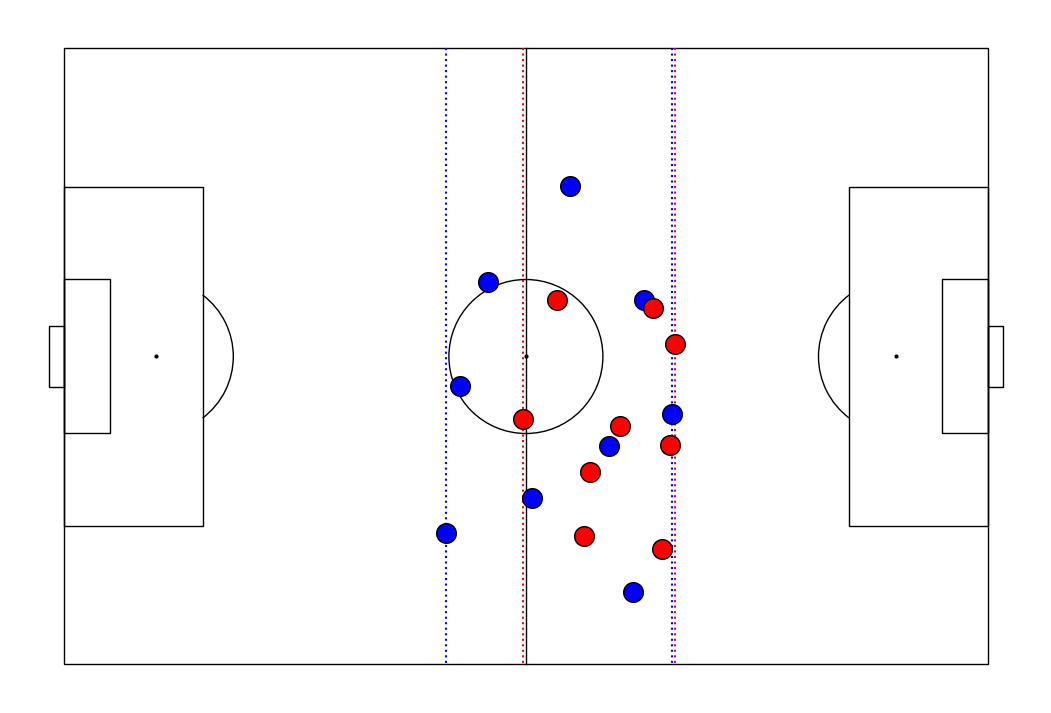

In [11]:
def draw_statsbomb_pitch(ax,
                         pitch_length=120, pitch_width=80,
                         origin_x=0, origin_y=0,
                         line_color="black", pitch_color="white",
                         linewidth=1, alpha=1):

    # Retângulo principal (campo)
    pitch = patches.Rectangle(
        (origin_x, origin_y),
        pitch_length,
        pitch_width,
        edgecolor=line_color,
        facecolor=pitch_color,
        lw=linewidth,
        alpha=alpha
    )
    ax.add_patch(pitch)
    
    # Linha central
    ax.plot([origin_x + pitch_length/2, origin_x + pitch_length/2],
            [origin_y, origin_y + pitch_width],
            color=line_color, lw=linewidth, alpha=alpha)
    
    # Círculo central e ponto central
    center = (origin_x + pitch_length/2, origin_y + pitch_width/2)
    center_circle = patches.Circle(center, radius=10, fill=False,
                                   edgecolor=line_color, lw=linewidth, alpha=alpha)
    ax.add_patch(center_circle)
    ax.plot(center[0], center[1], marker='o', markersize=2,
            color=line_color, alpha=alpha)
    
    # Áreas de pênalti (18 x 44)
    left_penalty = patches.Rectangle(
        (origin_x, origin_y + (pitch_width - 44)/2),
        18, 44, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(left_penalty)
    right_penalty = patches.Rectangle(
        (origin_x + pitch_length - 18, origin_y + (pitch_width - 44)/2),
        18, 44, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(right_penalty)
    
    # Áreas dos 6 metros (6 x 20)
    left_six = patches.Rectangle(
        (origin_x, origin_y + (pitch_width - 20)/2),
        6, 20, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(left_six)
    right_six = patches.Rectangle(
        (origin_x + pitch_length - 6, origin_y + (pitch_width - 20)/2),
        6, 20, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(right_six)
    
    # Pontos de pênalti
    ax.plot(origin_x + 12, origin_y + pitch_width/2,
            marker='o', markersize=2, color=line_color, alpha=alpha)
    ax.plot(origin_x + pitch_length - 12, origin_y + pitch_width/2,
            marker='o', markersize=2, color=line_color, alpha=alpha)
    
    # Arcos de pênalti
    left_arc = patches.Arc(
        (origin_x + 12, origin_y + pitch_width/2),
        20, 20,
        angle=0,
        theta1=-53,
        theta2=53,
        color=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(left_arc)
    right_arc = patches.Arc(
        (origin_x + pitch_length - 12, origin_y + pitch_width/2),
        20, 20,
        angle=0,
        theta1=127,
        theta2=233,
        color=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(right_arc)
    
    # Gols
    goal_width = 8
    goal_offset = 2
    left_goal = patches.Rectangle(
        (origin_x - goal_offset, origin_y + pitch_width/2 - goal_width/2),
        goal_offset, goal_width,
        fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(left_goal)
    right_goal = patches.Rectangle(
        (origin_x + pitch_length, origin_y + pitch_width/2 - goal_width/2),
        goal_offset, goal_width,
        fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha
    )
    ax.add_patch(right_goal)
    
    # Ajustes dos limites do plot
    ax.set_xlim(origin_x - goal_offset - 5, origin_x + pitch_length + goal_offset + 5)
    ax.set_ylim(origin_y - 5, origin_y + pitch_width + 5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Inverte o eixo Y para que a origem fique no canto superior esquerdo (estilo StatsBomb)
    ax.invert_yaxis()

def plot_scatter_players_on_field(freeze_frame, cor_time1, cor_time2, filter_team='both', include_keeper=True,
                             pitch_length=120, pitch_width=80, save_path="../Image/example_plot_scatter_players_on_field.png",
                             lines=False):
    # Cria a figura com fundo transparente
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='none')
    
    # Desenha o campo no estilo StatsBomb
    draw_statsbomb_pitch(ax, pitch_length=pitch_length, pitch_width=pitch_width)
    
    # Encontra o jogador que é o 'actor' (quem está com a bola)
    actor = next((player for player in freeze_frame if player['actor']), None)
    if actor is None:
        raise ValueError("Nenhum jogador com 'actor': True encontrado no freeze_frame.")
    
    teammate_actor = actor['teammate']  # True se o actor é do time A, False se é do time B
    
    # Se for para desenhar linhas, inicializa listas para armazenar as posições X de cada time
    if lines:
        x_positions_team_with_ball = []
        x_positions_team_without_ball = []
    
    # Plota os jogadores com base nos filtros
    for player in freeze_frame:
        # Exclui goleiros se include_keeper for False
        if not include_keeper and player['keeper']:
            continue
        
        # Filtra pelo time com a bola
        if filter_team == 'with_ball' and player['teammate'] != teammate_actor:
            continue
        # Filtra pelo time sem a bola
        if filter_team == 'without_ball' and player['teammate'] == teammate_actor:
            continue
        
        # Define a cor do jogador
        cor = cor_time1 if player['teammate'] else cor_time2
        
        if lines:
            # Pega as coordenadas e garante que fiquem dentro dos limites do campo
            x, y = player['location']
            x = max(0, min(x, pitch_length))
            y = max(0, min(y, pitch_width))
            # Armazena a posição X para desenho das linhas pontilhadas
            if player['teammate']:
                x_positions_team_with_ball.append(x)
            else:
                x_positions_team_without_ball.append(x)
        else:
            x, y = player['location']
        
        ax.scatter(x, y, s=200, facecolor=cor, edgecolor='black', zorder=3)
    
    # Se lines=True, desenha as linhas verticais pontilhadas
    if lines:
        def draw_vertical_dotted_line(ax, x_value, color):
            x_value = max(0, min(x_value, pitch_length))
            ax.plot([x_value, x_value], [0, pitch_width], color=color, linestyle=':', zorder=2)
        
        # Desenha para o time com bola
        if filter_team in ['with_ball', 'both']:
            if x_positions_team_with_ball:
                x_min = min(x_positions_team_with_ball)
                x_max = max(x_positions_team_with_ball)
                draw_vertical_dotted_line(ax, x_min, cor_time1)
                draw_vertical_dotted_line(ax, x_max, cor_time1)
        
        # Desenha para o time sem bola
        if filter_team in ['without_ball', 'both']:
            if x_positions_team_without_ball:
                x_min = min(x_positions_team_without_ball)
                x_max = max(x_positions_team_without_ball)
                draw_vertical_dotted_line(ax, x_min, cor_time2)
                draw_vertical_dotted_line(ax, x_max, cor_time2)
    
    # Salva a imagem com fundo transparente e exibe o gráfico
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()

event = df_on_360.iloc[500]
plot_scatter_players_on_field(event['freeze_frame'], cor_time1='blue', cor_time2='red', lines=True)


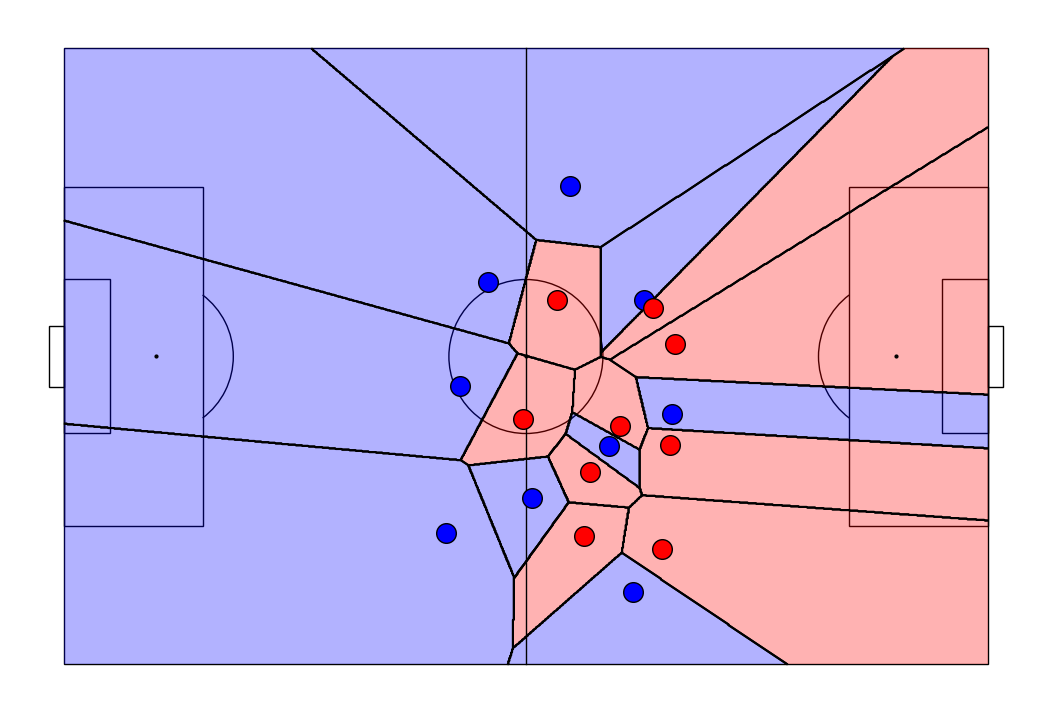

In [24]:
def plot_voronoi_field(freeze_frame, cor_time1, cor_time2,
                        pitch_length=120, pitch_width=80, 
                        save_path="../Image/example_plot_voronoi_field.png", resolution=1000):
    # Cria a figura com fundo transparente
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='none')
    
    # Desenha o campo (substitua essa função pela sua implementação)
    draw_statsbomb_pitch(ax, pitch_length=pitch_length, pitch_width=pitch_width)
    
    # Extrai as posições dos jogadores
    points = np.array([player['location'] for player in freeze_frame])
    
    # Cria uma grade de alta resolução sobre o campo
    grid_x, grid_y = np.meshgrid(np.linspace(0, pitch_length, resolution), 
                                 np.linspace(0, pitch_width, resolution))
    voronoi_regions = np.zeros(grid_x.shape, dtype=int)
    
    # Calcula a distância euclidiana para determinar as regiões
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            point = np.array([grid_x[i, j], grid_y[i, j]])
            distances = np.sqrt(((points - point)**2).sum(axis=1))
            voronoi_regions[i, j] = np.argmin(distances)
    
    # Mapeia as cores dos jogadores com base no time
    cores_jogadores = [cor_time1 if player['teammate'] else cor_time2 for player in freeze_frame]
    
    # Cria uma grade de cores para as regiões de Voronoi
    grid_cores = np.array(cores_jogadores)[voronoi_regions]
    
    # Define as bordas da grade para o pcolormesh
    x_edges = np.linspace(0, pitch_length, resolution + 1)
    y_edges = np.linspace(0, pitch_width, resolution + 1)
    
    # Cria um mapa de cores personalizado com as cores dos times
    unique_cores = list(set(cores_jogadores))  # Lista de cores únicas (cor_time1 e cor_time2)
    cmap = ListedColormap(unique_cores)
    
    # Converte as cores da grade para valores numéricos correspondentes
    cor_to_num = {cor: i for i, cor in enumerate(unique_cores)}
    num_grid = np.vectorize(cor_to_num.get)(grid_cores)
    
    # Plota as regiões de Voronoi preenchidas com transparência
    ax.pcolormesh(x_edges, y_edges, num_grid, cmap=cmap, alpha=0.3, shading='flat', zorder=1)
    
    # Desenha as fronteiras do Voronoi com linhas finas e contínuas
    for idx in range(len(points)):
        mask = voronoi_regions == idx
        ax.contour(grid_x, grid_y, mask, levels=[0.5], colors='black', linewidths=1.5, zorder=2)
    
    # Plota os jogadores
    for player in freeze_frame:
        x, y = player['location']
        cor = cor_time1 if player['teammate'] else cor_time2
        ax.scatter(x, y, s=200, facecolor=cor, edgecolor='black', zorder=3)
    
    # Salva a imagem com fundo transparente
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()

plot_voronoi_field(event['freeze_frame'], cor_time1='blue', cor_time2='red')

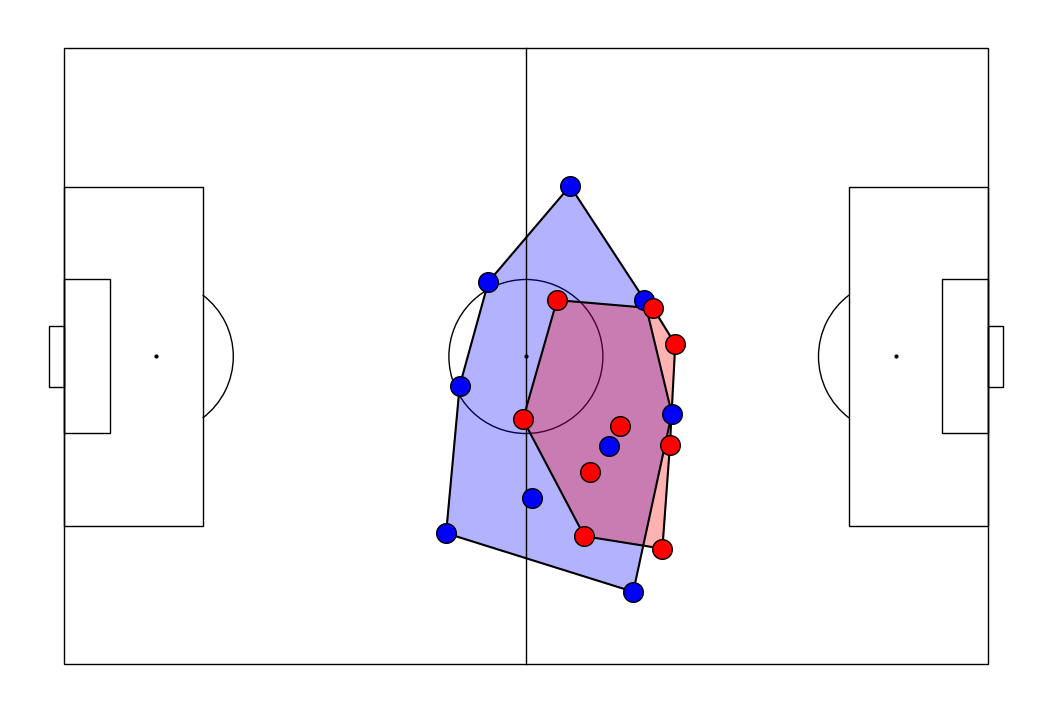

In [16]:
def plot_convexhull(freeze_frame, cor_time1, cor_time2, filter_team='both',
                           pitch_length=120, pitch_width=80, save_path="../Image/example_plot_convexhull.png"):
    # Cria a figura com fundo transparente
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='none')
    
    # Desenha o campo no estilo StatsBomb (função fictícia, assumida existente)
    draw_statsbomb_pitch(ax, pitch_length=pitch_length, pitch_width=pitch_width)
    
    # Identifica o jogador com a bola ('actor')
    actor = next((player for player in freeze_frame if player['actor']), None)
    if actor is None:
        raise ValueError("Nenhum 'actor' encontrado no freeze_frame.")
    
    teammate_actor = actor['teammate']  # True se o actor é do time com a bola
    
    # Separa os times, excluindo goleiros
    team_with_ball = [p for p in freeze_frame if p['teammate'] == teammate_actor and not p['keeper']]
    team_without_ball = [p for p in freeze_frame if p['teammate'] != teammate_actor and not p['keeper']]
    
    # Define quais times plotar baseado no filtro
    if filter_team == 'with_ball':
        teams_to_plot = [team_with_ball]
        colors = [cor_time1]
    elif filter_team == 'without_ball':
        teams_to_plot = [team_without_ball]
        colors = [cor_time2]
    else:  # 'both'
        teams_to_plot = [team_with_ball, team_without_ball]
        colors = [cor_time1, cor_time2]
    
    # Função para calcular o convex hull (Graham Scan)
    def convex_hull_graham(points):
        if len(points) < 3:
            return points
        
        def cross_product(p0, p1, p2):
            return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p1[1] - p0[1]) * (p2[0] - p0[0])
        
        points = sorted(points, key=lambda p: (p[0], p[1]))
        start = points[0]
        remaining = sorted(points[1:], key=lambda p: (np.arctan2(p[1] - start[1], p[0] - start[0]), 
                                                       (p[0] - start[0])**2 + (p[1] - start[1])**2))
        
        hull = [start]
        for point in remaining + [start]:
            while len(hull) >= 2 and cross_product(hull[-2], hull[-1], point) <= 0:
                hull.pop()
            hull.append(point)
        return hull[:-1]
    
    # Plota os jogadores e convex hulls
    for team, color in zip(teams_to_plot, colors):
        # Plota os jogadores
        for player in team:
            x, y = player['location']
            ax.scatter(x, y, s=200, facecolor=color, edgecolor='black', zorder=3)
        
        # Calcula e plota o convex hull se houver 3 ou mais jogadores
        if len(team) >= 3:
            points = [player['location'] for player in team]
            hull_points = convex_hull_graham(points)
            hull_x = [p[0] for p in hull_points]
            hull_y = [p[1] for p in hull_points]
            
            # Preenchimento com cor do time e transparência
            ax.fill(hull_x, hull_y, color=color, alpha=0.3, zorder=1)
            # Linhas pretas do convex hull
            ax.plot(hull_x + [hull_x[0]], hull_y + [hull_y[0]], color='black', lw=1.5, zorder=2)
        else:
            print(f"Time com {len(team)} jogadores. Convex hull não calculado.")
    
    # Salva a imagem com fundo transparente
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()

plot_convexhull(event['freeze_frame'], cor_time1='blue', cor_time2='red')

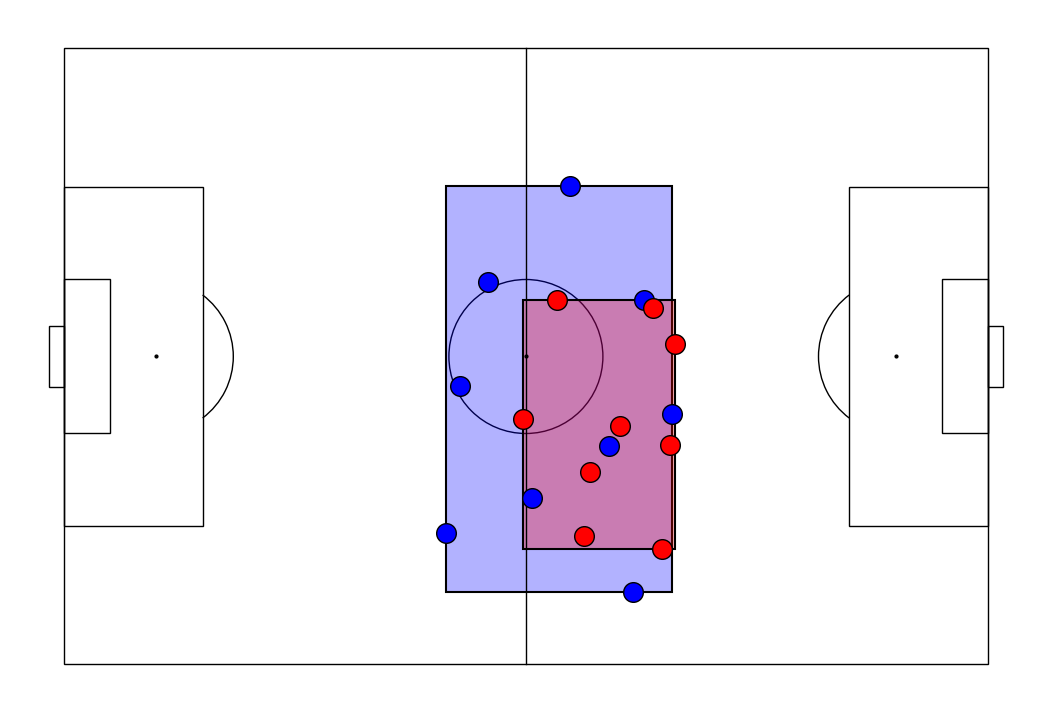

In [17]:
def plot_box_field(freeze_frame, cor_time1, cor_time2, filter_team='both',
                                        pitch_length=120, pitch_width=80, save_path="../Image/example_plot_box_field.png"):
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='none')
    
    draw_statsbomb_pitch(ax, pitch_length=pitch_length, pitch_width=pitch_width)
    
    actor = next((player for player in freeze_frame if player['actor']), None)
    if actor is None:
        raise ValueError("Nenhum 'actor' encontrado no freeze_frame.")
    
    teammate_actor = actor['teammate'] 
    
    team_with_ball = [p for p in freeze_frame if p['teammate'] == teammate_actor and not p['keeper']]
    team_without_ball = [p for p in freeze_frame if p['teammate'] != teammate_actor and not p['keeper']]

    if filter_team == 'with_ball':
        teams_to_plot = [team_with_ball]
        colors = [cor_time1]
    elif filter_team == 'without_ball':
        teams_to_plot = [team_without_ball]
        colors = [cor_time2]
    else:  # 'both'
        teams_to_plot = [team_with_ball, team_without_ball]
        colors = [cor_time1, cor_time2]

    for team, color in zip(teams_to_plot, colors):
        for player in team:
            x, y = player['location']
            ax.scatter(x, y, s=200, facecolor=color, edgecolor='black', zorder=3)

        if team:
            points = np.array([player['location'] for player in team])
            min_x, min_y = points.min(axis=0)
            max_x, max_y = points.max(axis=0)
            
            face_rgba = to_rgba(color, alpha=0.3)
            
            rect = plt.Rectangle(
                (min_x, min_y),
                max_x - min_x,
                max_y - min_y,
                facecolor=face_rgba,     
                edgecolor='black',       
                linewidth=1.5,             
                zorder=1
            )
            
            ax.add_patch(rect)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()
    
plot_box_field(event['freeze_frame'], cor_time1='blue', cor_time2='red')

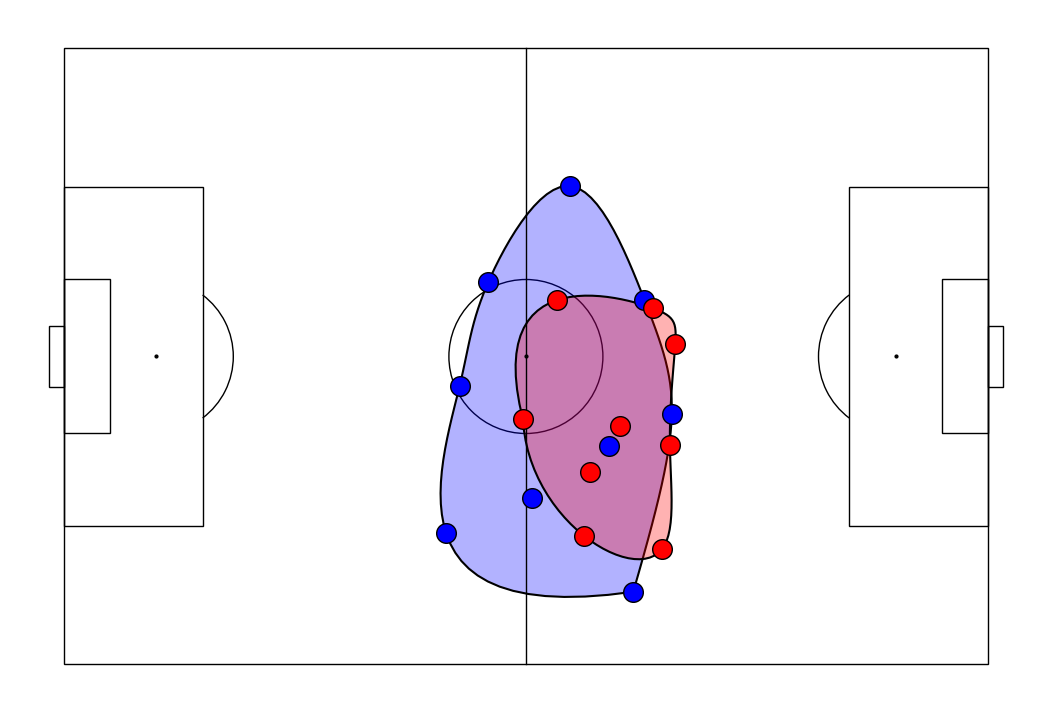

In [ ]:
def plot_convexhull_curve(freeze_frame, cor_time1, cor_time2, filter_team='both',
                                         pitch_length=120, pitch_width=80, save_path="../Image/example_plot_convexhull_curve.png"):
    # Cria a figura com fundo transparente
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='none')
    
    # Desenha o campo (função fictícia, assumida existente)
    draw_statsbomb_pitch(ax, pitch_length=pitch_length, pitch_width=pitch_width)
    
    # Identifica o jogador com a bola ('actor')
    actor = next((player for player in freeze_frame if player['actor']), None)
    if actor is None:
        raise ValueError("Nenhum 'actor' encontrado no freeze_frame.")
    
    teammate_actor = actor['teammate']  # True se o actor é do time com a bola
    
    # Separa os times, excluindo goleiros
    team_with_ball = [p for p in freeze_frame if p['teammate'] == teammate_actor and not p['keeper']]
    team_without_ball = [p for p in freeze_frame if p['teammate'] != teammate_actor and not p['keeper']]
    
    # Define quais times plotar baseado no filtro
    if filter_team == 'with_ball':
        teams_to_plot = [team_with_ball]
        colors = [cor_time1]
    elif filter_team == 'without_ball':
        teams_to_plot = [team_without_ball]
        colors = [cor_time2]
    else:  # 'both'
        teams_to_plot = [team_with_ball, team_without_ball]
        colors = [cor_time1, cor_time2]
    
    # Plota os jogadores e a região suave envolvendo os jogadores
    for team, color in zip(teams_to_plot, colors):
        # Plota os jogadores
        for player in team:
            x, y = player['location']
            ax.scatter(x, y, s=200, facecolor=color, edgecolor='black', zorder=3)
        
        # Se houverem ao menos 3 jogadores, tenta suavizar o contorno
        if len(team) >= 3:
            # Extrai as localizações
            points = np.array([player['location'] for player in team])
            # Calcula o convex hull (contorno convexo dos pontos)
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            # Fecha o contorno para interpolação (repete o primeiro ponto)
            hull_points = np.vstack([hull_points, hull_points[0]])
            
            # Cria um parâmetro 't' para os pontos e interpola com splines (cúbicas)
            t = np.linspace(0, 1, len(hull_points))
            t_dense = np.linspace(0, 1, 100)
            spline_x = make_interp_spline(t, hull_points[:, 0], k=3)
            spline_y = make_interp_spline(t, hull_points[:, 1], k=3)
            x_smooth = spline_x(t_dense)
            y_smooth = spline_y(t_dense)
            
            # Define a cor com transparência
            face_rgba = to_rgba(color, alpha=0.3)
            
            # Plota a região preenchida com a curva suave
            ax.fill(x_smooth, y_smooth, facecolor=face_rgba, edgecolor='black', linewidth=1.5, zorder=1)
        else:
            # Se houver menos de 3 jogadores, plota círculos ao redor de cada jogador como fallback
            for player in team:
                x, y = player['location']
                face_rgba = to_rgba(color, alpha=0.3)
                circle = plt.Circle((x, y), radius=2, facecolor=face_rgba, edgecolor='black', linewidth=1.5, zorder=1)
                ax.add_patch(circle)
    
    # Salva a imagem com fundo transparente
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()
plot_convexhull_curve(event['freeze_frame'], cor_time1='blue', cor_time2='red')